In [1]:
import numpy as np
import sys
sys.path.append('../')
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from src.Mondrian_forest import *
from sklearn.metrics import mean_squared_error

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 5000
rotation = special_ortho_group.rvs(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [100,500,2000,5000]

In [2]:
M = 10                      # number of Mondrian trees to use
lifetime_max = 4          # terminal lifetime
delta = 0.1              # ridge regression delta

In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n
true_H = true_H / two_one_norm(true_H)

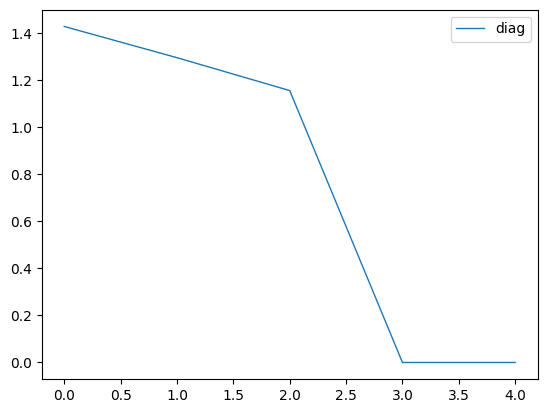

In [4]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [5]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    _, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

In [6]:
for n_sim in [sample_range[0]]:
    for lifetime in [1,2,3,4,5,6,7,8,9,10]:
        for round in range(2):
            print(f"n_sim: {n_sim}, lifetime: {lifetime}")
            mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime, delta, H = true_H)
            print(mse_best)

n_sim: 100, lifetime: 1
0.8392059
n_sim: 100, lifetime: 1
0.84904826
n_sim: 100, lifetime: 2
0.80263615
n_sim: 100, lifetime: 2
0.8073573
n_sim: 100, lifetime: 3
0.8057456
n_sim: 100, lifetime: 3
0.8128209
n_sim: 100, lifetime: 4
0.78486514
n_sim: 100, lifetime: 4
0.797461
n_sim: 100, lifetime: 5
0.77753407
n_sim: 100, lifetime: 5
0.769072
n_sim: 100, lifetime: 6
0.8072859
n_sim: 100, lifetime: 6
0.8025378
n_sim: 100, lifetime: 7
0.7950394
n_sim: 100, lifetime: 7
0.8000059
n_sim: 100, lifetime: 8
0.80314195
n_sim: 100, lifetime: 8
0.8224019
n_sim: 100, lifetime: 9
0.77386427
n_sim: 100, lifetime: 9
0.79758567
n_sim: 100, lifetime: 10
0.7696611
n_sim: 100, lifetime: 10
0.79340494


In [7]:
from numpy.linalg import norm
from tqdm import tqdm

In [8]:
lifetime_max = 5

stats = []
for n_sim in sample_range:
    dist = {'n': n_sim, 'dist': []}
    for trial in tqdm(range(5)):
        lifetime = lifetime_max * ((n_sim / sample_range[0]) ** (-2/5))
        mse, X_bd_all, X, history, w_trees, y_hat_train = \
            train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime, delta)
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, X, history, w_trees, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        dist['dist'].append((norm(H_0 - true_H, ord = 'fro')))
    stats.append(dist)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


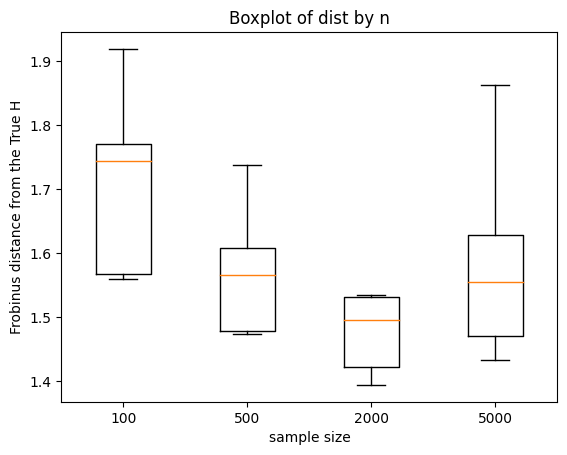

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(stats)

# Prepare the data for plotting
plot_data = [df['dist'][i] for i in range(len(df))]

# Create the boxplot
plt.boxplot(plot_data, labels=[str(x['n']) for x in stats])

# Add titles and labels
plt.title('Boxplot of dist by n')
plt.xlabel('sample size')
plt.ylabel('Frobinus distance from the True H')

# Show the plot
plt.show()